In [134]:
import pandas as pd 
import math
import numpy as np
from sklearn.cluster import KMeans 
from matplotlib import pyplot as plt 
import pylab as pl

import matplotlib.pyplot as plt; plt.rcdefaults()

row_data = pd.read_csv('data/tbl_reading_style.csv')

#remove user 111 and session that is too long
row_data = row_data[row_data['relative_time'] < 2000]
row_data = row_data[(row_data['reading_duration'] > 2)]
data = row_data[row_data['user_id'] != 111].copy()



data['max_offset'] = data['max_offset'].astype('int')
data['min_offset'] = data['min_offset'].astype('int')
data['offset_difference'] = data['offset_difference'].astype('int')
data['relative_time'] = data['relative_time'].astype('int')

# print(data.head())
# print(data.shape)
data.head()  #this is the aggregated dataset 






,user_id,reading_session,article_id,scroll_range,max_offset,min_offset,offset_difference,relative_time,reading_duration
104,122,97da3dcc-eb6e-428a-b9fb-4fd992e33983,36522510,7770,581,10,571,0,6
105,122,97da3dcc-eb6e-428a-b9fb-4fd992e33983,36522510,7770,944,613,331,1,6
106,122,97da3dcc-eb6e-428a-b9fb-4fd992e33983,36522510,7770,1083,785,298,3,6
107,122,97da3dcc-eb6e-428a-b9fb-4fd992e33983,36522510,7770,1604,1088,516,4,6
108,122,97da3dcc-eb6e-428a-b9fb-4fd992e33983,36522510,7770,2040,1614,426,5,6


In [135]:
grouped_data = data.groupby(['reading_session','article_id'])

# Evaleating higher-level features based on projetc's  reading style hypothesises 

#  major_section computaion 

In [136]:
major_section = {}
for group in grouped_data:
    #define the position for each session

    article_id = str(group[0][1])
    reading_session = str(group[0][0])
    reading_SA = article_id +" "+ reading_session
    
    label = -1 
    time_span_begin = 0
    time_span_middle = 0
    time_span_end = 0
    offset_max = group[1]['max_offset'].max()
    time_max = group[1]['relative_time'].max()+1
    offset_first = 1900
    offset_second = group[1]['scroll_range'].max()-1900
    
    group_sorted = group[1].sort_values('relative_time')
    prev_relative_time = 0
    time_span_begin = 0
    time_span_middle = 0
    time_span_end = 0
    for index, row in group_sorted.iterrows():
        #get the ending offset in this second
        if row['offset_difference'] >= 0:
            current_start_offset = row['min_offset'] 
        else:
            current_start_offset = row['max_offset']
        
        current_relative_time = row['relative_time']+1
        
        time_span = current_relative_time-prev_relative_time
        if current_start_offset < offset_first:
            time_span_begin += time_span
        #elif current_start_offset >= offset_first and current_start_offset <= offset_second:
        #    time_span_middle += time_span
        elif current_start_offset >= offset_second:
             time_span_end += time_span
        else:
            time_span_middle += time_span
        prev_relative_time = current_relative_time
        
        if time_span_begin > time_span_middle:
            label = 1
        else:
            label = 2 
        
        if time_span_end > time_span_begin and  time_span_end > time_span_middle:
            label = 3 
        
        
        
    major_section[str(reading_SA)]={}
    major_section[str(reading_SA)]['begin'] = time_span_begin/time_max
    major_section[str(reading_SA)]['middle'] = time_span_middle/time_max
    major_section[str(reading_SA)]['end'] = time_span_end/time_max
    major_section[str(reading_SA)]['major_section'] = label
    

In [137]:
major_section = pd.DataFrame.from_dict(major_section)
major_section = major_section.T
major_section.head()

,begin,end,major_section,middle
36723486 009b8175-f1ca-4f76-be13-5673098f2d14,0.200000,0.0,2.0,0.800000
36726095 009b8175-f1ca-4f76-be13-5673098f2d14,0.130435,0.0,2.0,0.869565
36734377 009b8175-f1ca-4f76-be13-5673098f2d14,0.809524,0.0,1.0,0.190476
36736571 009b8175-f1ca-4f76-be13-5673098f2d14,0.833333,0.0,1.0,0.166667
36677028 02a76bc1-0d5b-43da-ad5c-f52c8472502c,0.750000,0.0,1.0,0.250000


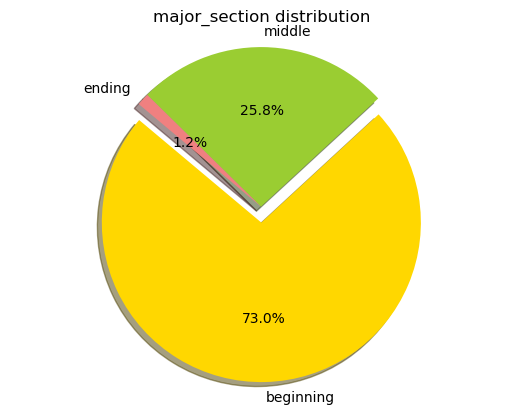

In [138]:

# 351 beginning 
# 124 miidle 
# 6


labels =  'beginning', 'middle', 'ending'
sizes = [ 351, 124, 6]
# colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','magenta','lightcoral','gold']
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0,0, )  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("major_section distribution")
plt.axis('equal')
plt.show()

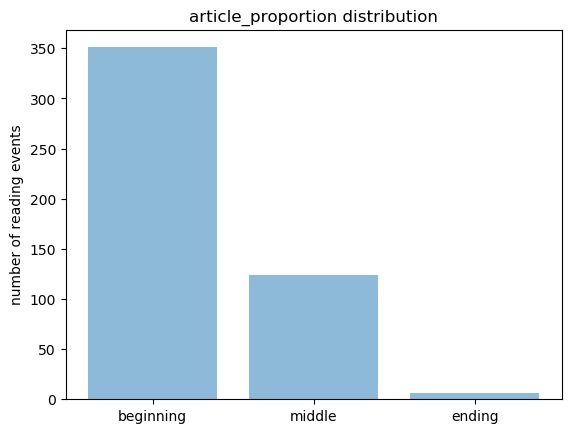

In [139]:
objects =  ('beginning', 'middle', 'ending')
y_pos = np.arange(len(objects))
performance  = [ 351, 124, 6]



plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of reading events')
plt.title('article_proportion distribution')
 
plt.show()

# article_proportion computation

In [140]:
article_proportion_feature = {}

for group in grouped_data:
    #define the position for each session
    postion_ratio = 0 
    scroll_range = 0
    max_offset = 0
    article_id = str(group[0][1])
    reading_session = str(group[0][0])
    reading_SA = article_id +" "+ reading_session
    max_offset = group[1]['max_offset'].max()
    scroll_range = group[1]['scroll_range'].max()
    position_ratio = max_offset/scroll_range    
   
    article_proportion_feature[str(reading_SA)] = {}
    article_proportion_feature[str(reading_SA)]['article_proportion'] = position_ratio


# print(position_article)

In [141]:
article_proportion_feature = pd.DataFrame.from_dict(article_proportion_feature)
article_proportion_feature = article_proportion_feature.T
article_proportion_feature.head()


,article_proportion
36723486 009b8175-f1ca-4f76-be13-5673098f2d14,0.663172
36726095 009b8175-f1ca-4f76-be13-5673098f2d14,0.811029
36734377 009b8175-f1ca-4f76-be13-5673098f2d14,0.528821
36736571 009b8175-f1ca-4f76-be13-5673098f2d14,0.756974
36677028 02a76bc1-0d5b-43da-ad5c-f52c8472502c,0.748530


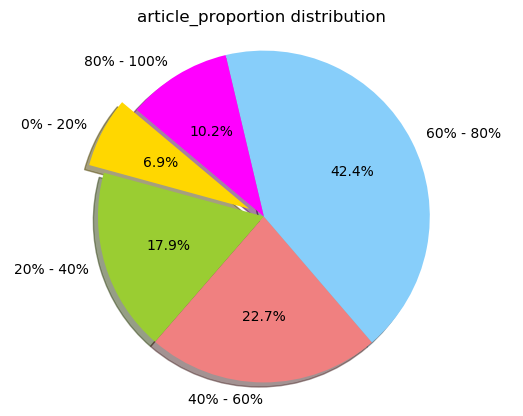

In [142]:
one=0 
two=0
three=0
four=0
five=0
six=0
seven=0
eight=0
night=0
ten=0

y = article_proportion_feature['article_proportion'].values

for article_proportion in y: 
    if article_proportion >=0 and article_proportion<=0.2:
        two = two +1
    elif article_proportion >0.2 and article_proportion<=0.4:
        four = four +1
    elif article_proportion >0.3 and article_proportion<=0.6:
        six = six +1
    elif article_proportion >0.6 and article_proportion<=0.8:
        eight = eight +1
    elif article_proportion >0.8 and article_proportion<=1:
        ten = ten +1
    
labels =  '0% - 20%', '20% - 40%', '40% - 60%', '60% - 80%', '80% - 100%'
sizes = [ two,  four,six,eight,ten]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','magenta']
explode = (0.1, 0, 0, 0,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("article_proportion distribution")
plt.axis('equal')
plt.show()

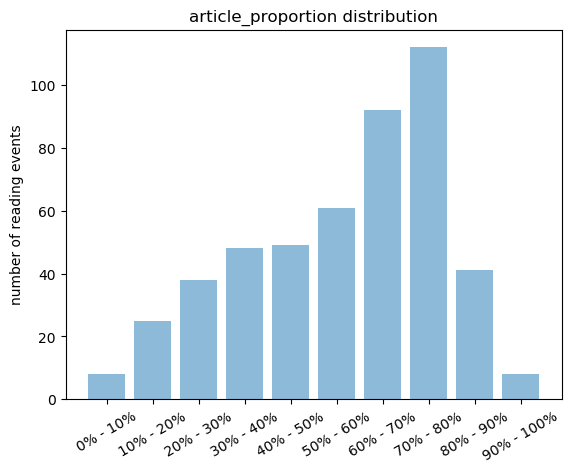

In [143]:
one=0 
two=0
three=0
four=0
five=0
six=0
seven=0
eight=0
night=0
ten=0
y = article_proportion_feature['article_proportion'].values
for article_proportion in y: 
    if article_proportion >=0 and article_proportion<=0.1:
        one = one +1
    elif article_proportion >0.1 and article_proportion<=0.2:
        two = two +1
    elif article_proportion >0.2 and article_proportion<=0.3:
        three = three +1
    elif article_proportion >0.3 and article_proportion<=0.4:
        four = four +1
    elif article_proportion >0.4 and article_proportion<=0.5:
        five = five +1
    elif article_proportion >0.5 and article_proportion<=0.6:
        six = six +1
    elif article_proportion >0.6 and article_proportion<=0.7:
        seven = seven +1
    elif article_proportion >0.7 and article_proportion<=0.8:
        eight = eight +1
    elif article_proportion >0.8 and article_proportion<=0.9:
        night = night +1
    elif article_proportion >0.9 and article_proportion<=1:
        ten = ten +1

objects = ('0% - 10%', '10% - 20%', '20% - 30%','30% - 40%', '40% - 50%','50% - 60%', '60% - 70%', '70% - 80%','80% - 90%','90% - 100%')
y_pos = np.arange(len(objects))
performance = [8, 25, 38, 48, 49, 61, 92, 112, 41, 8]


plt.xticks( rotation=30)
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of reading events')
plt.title('article_proportion distribution')
 
plt.show()


# jump_ratio computaion

In [144]:
jump_ratio_feature={}
for group in grouped_data:
    jump = 0
    numberOfScoll = 0
    data = group[1]
    article_id = str(group[0][1])
    reading_session = str(group[0][0])
    reading_SA = article_id +" "+ reading_session

    for diff in group[1]['offset_difference']:
        numberOfScoll += 1
        if diff > 220 or diff < -220:
            jump += 1
    
    jump_ratio = jump/numberOfScoll

        
  
    jump_ratio_feature[str(reading_SA)] = {}
    jump_ratio_feature[str(reading_SA)]['jump_ratio'] = jump_ratio



In [145]:
jump_ratio_feature = pd.DataFrame.from_dict(jump_ratio_feature)
jump_ratio_feature = jump_ratio_feature.T
jump_ratio_feature.head()




,jump_ratio
36723486 009b8175-f1ca-4f76-be13-5673098f2d14,0.368421
36726095 009b8175-f1ca-4f76-be13-5673098f2d14,0.714286
36734377 009b8175-f1ca-4f76-be13-5673098f2d14,0.650000
36736571 009b8175-f1ca-4f76-be13-5673098f2d14,1.000000
36677028 02a76bc1-0d5b-43da-ad5c-f52c8472502c,0.260870


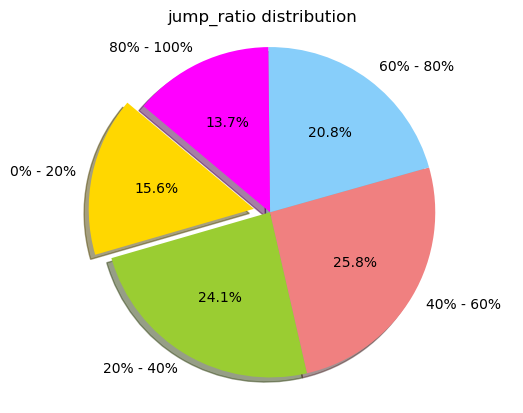

In [146]:
one=0 
two=0
three=0
four=0
five=0
six=0
seven=0
eight=0
night=0
ten=0
y = jump_ratio_feature['jump_ratio'].values


for position_ratio in y: 
    if position_ratio >=0 and position_ratio<=0.2:
        two = two +1
    elif position_ratio >0.2 and position_ratio<=0.4:
        four = four +1
    elif position_ratio >0.3 and position_ratio<=0.6:
        six = six +1
    elif position_ratio >0.6 and position_ratio<=0.8:
        eight = eight +1
    elif position_ratio >0.8 and position_ratio<=1:
        ten = ten +1
    
labels =  '0% - 20%', '20% - 40%', '40% - 60%', '60% - 80%', '80% - 100%'
sizes = [ two,  four,six,eight,ten]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','magenta']
explode = (0.1, 0, 0, 0,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("jump_ratio distribution")
plt.axis('equal')
plt.show()



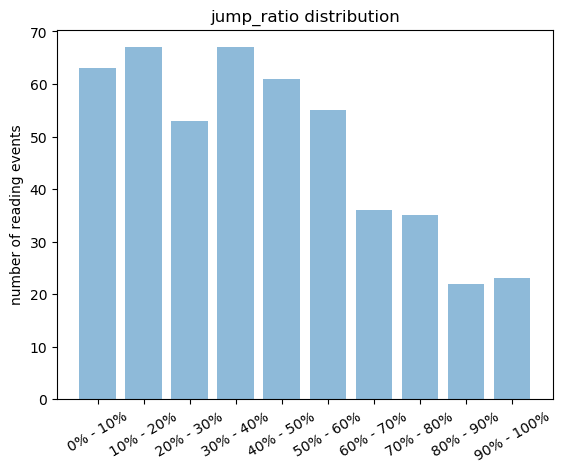

In [147]:
one=0 
two=0
three=0
four=0
five=0
six=0
seven=0
eight=0
night=0
ten=0
jump= jump_ratio_feature['jump_ratio'].values

for jump_ratio in jump: 
    if jump_ratio >=0 and jump_ratio<=0.1:
        one = one +1
    elif jump_ratio >0.1 and jump_ratio<=0.2:
        two = two +1
    elif jump_ratio >0.2 and jump_ratio<=0.3:
        three = three +1
    elif jump_ratio >0.3 and jump_ratio<=0.4:
        four = four +1
    elif jump_ratio >0.4 and jump_ratio<=0.5:
        five = five +1
    elif jump_ratio >0.5 and jump_ratio<=0.6:
        six = six +1
    elif jump_ratio >0.6 and jump_ratio<=0.7:
        seven = seven +1
    elif jump_ratio >0.7 and jump_ratio<=0.8:
        eight = eight +1
    elif jump_ratio >0.8 and jump_ratio<=0.9:
        night = night +1
    elif jump_ratio >0.9 and jump_ratio<=1:
        ten = ten +1
y = [one,two,three,four,five,six,seven,eight,night,ten]


 
objects = ('0% - 10%', '10% - 20%', '20% - 30%','30% - 40%', '40% - 50%','50% - 60%', '60% - 70%', '70% - 80%','80% - 90%','90% - 100%')
y_pos = np.arange(len(objects))
performance = [63, 67, 53, 67, 61, 55, 36, 35, 22, 23]


plt.xticks( rotation=30)
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of reading events')
plt.title('jump_ratio distribution')
 
plt.show()

# actual_reading_time_ratio computation

In [148]:
actual_reading_time_ratio_feature = {}
for group in grouped_data:
    #print(group)
    count = 0
    article_id = str(group[0][1])
    reading_session = str(group[0][0])
    reading_SA = article_id +" "+ reading_session

    max_offset = group[1]['max_offset'].max()
    max_relative = group[1]['relative_time'].max() + 1
    
    for diff in group[1]['offset_difference']:
         if diff > 220 or diff < -220:
            count += 1
    
    actual_reading_time = max_relative - count 
    reading_time_ratio = int(actual_reading_time)/max_relative
    #print(reading_time_ratio)
    
    actual_reading_time_ratio_feature[str(reading_SA)]={}
    actual_reading_time_ratio_feature[str(reading_SA)]['actual_reading_time'] = actual_reading_time
    actual_reading_time_ratio_feature[str(reading_SA)]['actual_reading_time_ratio'] = reading_time_ratio
    actual_reading_time_ratio_feature[str(reading_SA)]['max_relative'] = max_relative


In [149]:
actual_reading_time_ratio_feature = pd.DataFrame.from_dict(actual_reading_time_ratio_feature)
actual_reading_time_ratio_feature = actual_reading_time_ratio_feature.T
actual_reading_time_ratio_feature.head()

,actual_reading_time,actual_reading_time_ratio,max_relative
36723486 009b8175-f1ca-4f76-be13-5673098f2d14,13.0,0.650000,20.0
36726095 009b8175-f1ca-4f76-be13-5673098f2d14,36.0,0.782609,46.0
36734377 009b8175-f1ca-4f76-be13-5673098f2d14,71.0,0.845238,84.0
36736571 009b8175-f1ca-4f76-be13-5673098f2d14,10.0,0.555556,18.0
36677028 02a76bc1-0d5b-43da-ad5c-f52c8472502c,38.0,0.863636,44.0


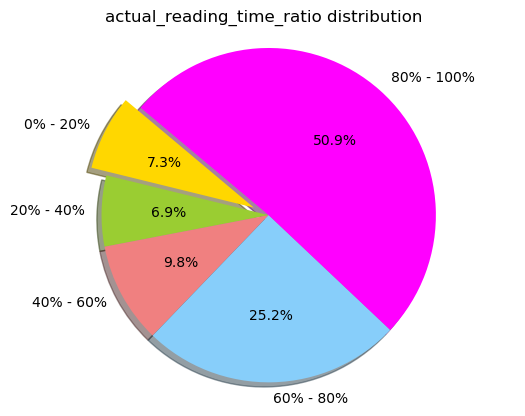

In [150]:
one=0 
two=0
three=0
four=0
five=0
six=0
seven=0
eight=0
night=0
ten=0
y = actual_reading_time_ratio_feature['actual_reading_time_ratio'].values

for reading_time_ratio in y: 
    if reading_time_ratio >=0 and reading_time_ratio<=0.2:
        two = two +1
    elif reading_time_ratio >0.2 and reading_time_ratio<=0.4:
        four = four +1
    elif reading_time_ratio >0.3 and reading_time_ratio<=0.6:
        six = six +1
    elif reading_time_ratio >0.6 and reading_time_ratio<=0.8:
        eight = eight +1
    elif reading_time_ratio >0.8 and reading_time_ratio<=1:
        ten = ten +1
    
labels =  '0% - 20%', '20% - 40%', '40% - 60%', '60% - 80%', '80% - 100%'
sizes = [ two,  four,six,eight,ten]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','magenta']
explode = (0.1, 0, 0, 0,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("actual_reading_time_ratio distribution")
plt.axis('equal')
plt.show()




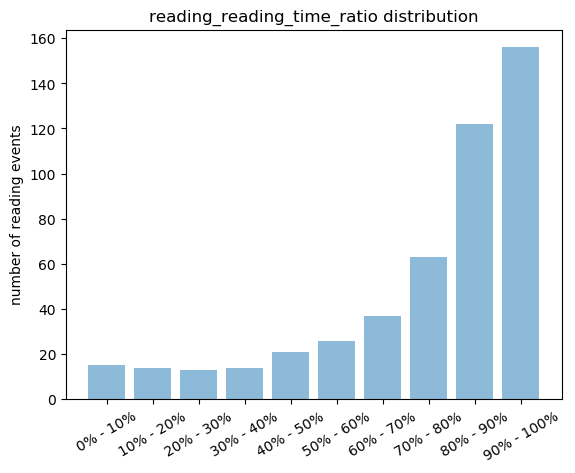

In [151]:
one=0 
two=0
three=0
four=0
five=0
six=0
seven=0
eight=0
night=0
ten=0
y = actual_reading_time_ratio_feature['actual_reading_time_ratio'].values

for actual_reading_time_ratio in y: 
    if actual_reading_time_ratio >=0 and actual_reading_time_ratio<=0.1:
        one = one +1
    elif actual_reading_time_ratio >0.1 and actual_reading_time_ratio<=0.2:
        two = two +1
    elif actual_reading_time_ratio >0.2 and actual_reading_time_ratio<=0.3:
        three = three +1
    elif actual_reading_time_ratio >0.3 and actual_reading_time_ratio<=0.4:
        four = four +1
    elif actual_reading_time_ratio >0.4 and actual_reading_time_ratio<=0.5:
        five = five +1
    elif actual_reading_time_ratio >0.5 and actual_reading_time_ratio<=0.6:
        six = six +1
    elif actual_reading_time_ratio >0.6 and actual_reading_time_ratio<=0.7:
        seven = seven +1
    elif actual_reading_time_ratio >0.7 and actual_reading_time_ratio<=0.8:
        eight = eight +1
    elif actual_reading_time_ratio >0.8 and actual_reading_time_ratio<=0.9:
        night = night +1
    elif actual_reading_time_ratio >0.9 and actual_reading_time_ratio<=1:
        ten = ten +1
y = [one,two,three,four,five,six,seven,eight,night,ten]


 
objects = ('0% - 10%', '10% - 20%', '20% - 30%','30% - 40%', '40% - 50%','50% - 60%', '60% - 70%', '70% - 80%','80% - 90%','90% - 100%')
y_pos = np.arange(len(objects))
performance = [15, 14, 13, 14, 21, 26, 37, 63, 122, 156]


plt.xticks( rotation=30)
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of reading events')
plt.title('reading_reading_time_ratio distribution')
 
plt.show()

# jumping_speed computation

In [152]:
jumping_speed_feature = {}
max_ratio = 0
min_ratio = 9999999999
skipped_time = 0
sum_offset_diff = 0
#min_ratio -> min_ratio+(max_ratio-min_ratio)*0.1
count = 0
for group in grouped_data:
    #print(group)
    data = group[1]
    article_id = str(group[0][1])
    reading_session = str(group[0][0])
    reading_SA = article_id +" "+ reading_session
    for diff in data['offset_difference']:
        if diff > 220:
            skipped_time += 1
            sum_offset_diff += diff
        if diff < -220:
            skipped_time += 1
            sum_offset_diff += -diff
    if skipped_time > 0:
        jumping_speed = sum_offset_diff/skipped_time
    jumping_speed_feature[str(reading_SA)]={}
    jumping_speed_feature[str(reading_SA)]['jumping_speed'] = jumping_speed


In [153]:
jumping_speed_feature = pd.DataFrame.from_dict(jumping_speed_feature)
jumping_speed_feature = jumping_speed_feature.T
jumping_speed_feature.head()
# print(browse_speed1['jumping_speed'].max())
# print(browse_speed1['jumping_speed'].min())

,jumping_speed
36723486 009b8175-f1ca-4f76-be13-5673098f2d14,555.428571
36726095 009b8175-f1ca-4f76-be13-5673098f2d14,691.235294
36734377 009b8175-f1ca-4f76-be13-5673098f2d14,561.633333
36736571 009b8175-f1ca-4f76-be13-5673098f2d14,626.921053
36677028 02a76bc1-0d5b-43da-ad5c-f52c8472502c,643.500000


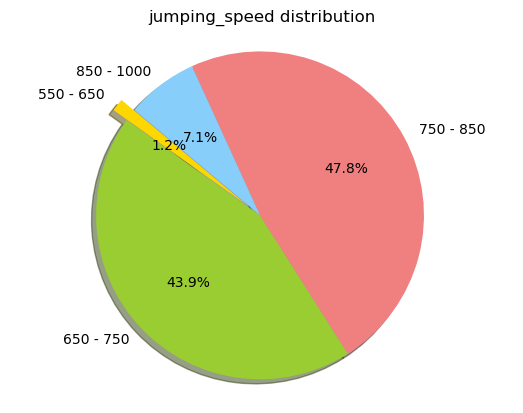

In [154]:
one=0 
two=0
three=0
four=0
five=0
six=0
seven=0
eight=0
night=0
ten=0
y = jumping_speed_feature['jumping_speed'].values


for jumping_speed in y: 
    if jumping_speed >=550 and jumping_speed<=650:
        one = one +1
    elif jumping_speed >650 and jumping_speed<=750:
        two = two +1
    elif jumping_speed >750 and jumping_speed<=850:
        three = three +1
    elif jumping_speed >850 and jumping_speed<=1000:
        four = four +1
    
labels =  '550 - 650', '650 - 750', '750 - 850', '850 - 1000'
sizes = [ one, two, three, four]
# colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','magenta','lightcoral','gold']
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0,0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("jumping_speed distribution")
plt.axis('equal')
plt.show()




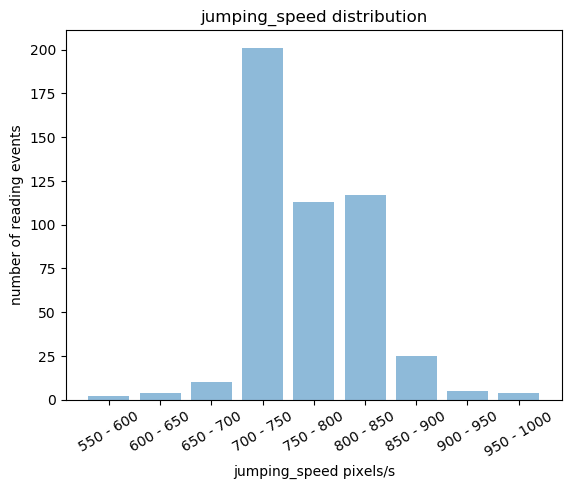

In [155]:
one=0 
two=0
three=0
four=0
five=0
six=0
seven=0
eight=0
night=0
ten=0
y = jumping_speed_feature['jumping_speed'].values

for jumping_speed in y: 
    if jumping_speed >=550 and jumping_speed<=600:
        one = one +1
    elif jumping_speed >600 and jumping_speed<=650:
        two = two +1
    elif jumping_speed >650 and jumping_speed<=700:
        three = three +1
    elif position_ratio >700 and jumping_speed<=750:
        four = four +1
    elif jumping_speed >750 and jumping_speed<=800:
        five = five +1
    elif jumping_speed >800 and jumping_speed<=850:
        six = six +1
    elif jumping_speed >850 and jumping_speed<=900:
        seven = seven +1
    elif jumping_speed >900 and jumping_speed<=950:
        eight = eight +1
    elif jumping_speed >950 and jumping_speed<=1000:
        night = night +1
    
y = [one,two,three,four,five,six,seven,eight,night,ten]


 
objects =  ('550 - 600', '600 - 650', '650 - 700', '700 - 750','750 - 800','800 - 850','850 - 900','900 - 950','950 - 1000')
y_pos = np.arange(len(objects))
performance  = [2, 4, 10, 201, 113, 117, 25, 5, 4]



plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation=30)


plt.ylabel('number of reading events')
plt.xlabel('jumping_speed pixels/s')

plt.title('jumping_speed distribution')
 
plt.show()



# combing all higher-level features into one single table 

In [156]:
result = pd.concat([jumping_speed_feature, actual_reading_time_ratio_feature, jump_ratio_feature,article_proportion_feature,major_section], axis=1, sort=False)
result.head()

,jumping_speed,actual_reading_time,actual_reading_time_ratio,max_relative,jump_ratio,article_proportion,begin,end,major_section,middle
36723486 009b8175-f1ca-4f76-be13-5673098f2d14,555.428571,13.0,0.650000,20.0,0.368421,0.663172,0.200000,0.0,2.0,0.800000
36726095 009b8175-f1ca-4f76-be13-5673098f2d14,691.235294,36.0,0.782609,46.0,0.714286,0.811029,0.130435,0.0,2.0,0.869565
36734377 009b8175-f1ca-4f76-be13-5673098f2d14,561.633333,71.0,0.845238,84.0,0.650000,0.528821,0.809524,0.0,1.0,0.190476
36736571 009b8175-f1ca-4f76-be13-5673098f2d14,626.921053,10.0,0.555556,18.0,1.000000,0.756974,0.833333,0.0,1.0,0.166667
36677028 02a76bc1-0d5b-43da-ad5c-f52c8472502c,643.500000,38.0,0.863636,44.0,0.260870,0.748530,0.750000,0.0,1.0,0.250000


# combing the five higher level features as cluster factors

In [157]:
ana_data =  result[['jumping_speed','jump_ratio','actual_reading_time_ratio','article_proportion','major_section']]
ana_data.head()


,jumping_speed,jump_ratio,actual_reading_time_ratio,article_proportion,major_section
36723486 009b8175-f1ca-4f76-be13-5673098f2d14,555.428571,0.368421,0.650000,0.663172,2.0
36726095 009b8175-f1ca-4f76-be13-5673098f2d14,691.235294,0.714286,0.782609,0.811029,2.0
36734377 009b8175-f1ca-4f76-be13-5673098f2d14,561.633333,0.650000,0.845238,0.528821,1.0
36736571 009b8175-f1ca-4f76-be13-5673098f2d14,626.921053,1.000000,0.555556,0.756974,1.0
36677028 02a76bc1-0d5b-43da-ad5c-f52c8472502c,643.500000,0.260870,0.863636,0.748530,1.0


In [158]:
from sklearn.preprocessing import StandardScaler
features = ['jumping_speed','jump_ratio','actual_reading_time_ratio','article_proportion','major_section']
# Separating out the features
x_full = ana_data.loc[:, features].values

x = x_full.copy()
print(x)
x = StandardScaler().fit_transform(x)
#transformation here
print(x.shape)
print(x)

[[5.55428571e+02 3.68421053e-01 6.50000000e-01 6.63171691e-01
  2.00000000e+00]
 [6.91235294e+02 7.14285714e-01 7.82608696e-01 8.11029412e-01
  2.00000000e+00]
 [5.61633333e+02 6.50000000e-01 8.45238095e-01 5.28820817e-01
  1.00000000e+00]
 ...
 [7.23294969e+02 5.29411765e-01 7.80487805e-01 5.34953924e-01
  1.00000000e+00]
 [7.22663058e+02 5.00000000e-01 5.33333333e-01 7.45434422e-01
  1.00000000e+00]
 [7.22904029e+02 7.14285714e-01 2.85714286e-01 2.52998379e-01
  1.00000000e+00]]
(481, 5)
[[-4.00858108 -0.50006739 -0.28046278  0.46257974  1.50295769]
 [-1.48209911  0.80031005  0.24637731  1.16044264  1.50295769]
 [-3.89315071  0.55860946  0.49519718 -0.17153318 -0.59247028]
 ...
 [-0.88567657  0.10522339  0.23795124 -0.14258597 -0.59247028]
 [-0.89743234 -0.00535858 -0.74396691  0.85084562 -0.59247028]
 [-0.89294943  0.80031005 -1.72773077 -1.47336745 -0.59247028]]


# reduce dataset dimensionality by PCA and visualise dataset

In [159]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

(481,)
(481,)
(481, 2)


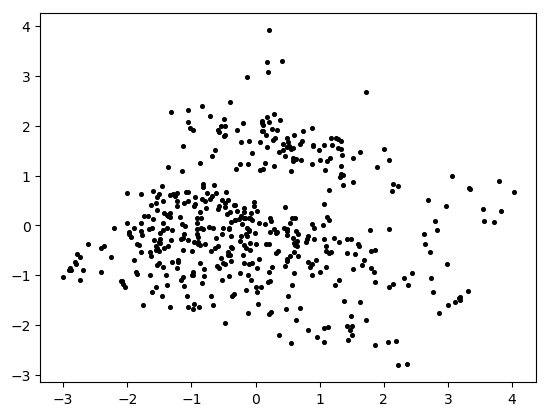

In [160]:
f1 = principalDf['principal component 1'].values
print(f1.shape)
f2= principalDf['principal component 2'].values
print(f2.shape)
x = np.array(list(zip(f1,f2)))
# print(x)
print(x.shape)
plt.scatter(f1,f2, c='black', s=7)
#filter data 1.filtered() 2.sql 



#clustering BY KMEANS

In [161]:
#num of clusters 
k = 3
kmeans = KMeans(n_clusters=k)

kmeans = kmeans.fit(x) #search in web
labels = kmeans.predict(x)
print(len(labels))
print(len(x))
print(len(principalDf))
centroids = kmeans.cluster_centers_
print(centroids) # five centres's coordiantion


481
481
481
[[-0.97976851 -0.29622769]
 [ 0.39162064  1.69600598]
 [ 1.52034946 -0.77133791]]


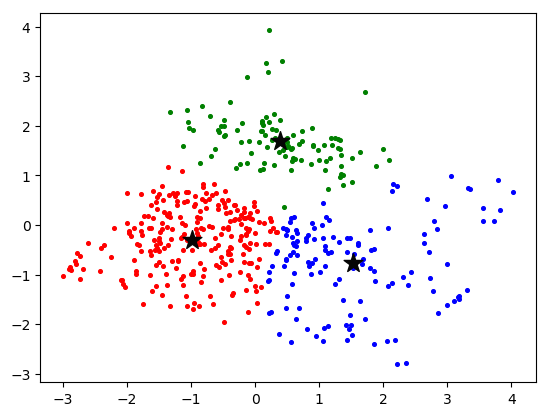

In [162]:
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([x[j] for j in range(len(x)) if labels[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='#050505') #five centres drawn by makers 

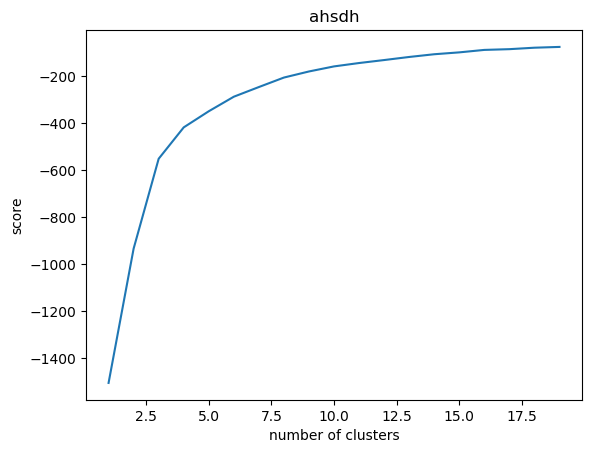

In [163]:
Nc = range(1,20)
kmeans = [KMeans(n_clusters = i) for i in Nc] 
score = [kmeans[i].fit(x).score(x) for i in range(len(kmeans))]
pl.plot(Nc, score)
pl.xlabel('number of clusters')
pl.ylabel('score')
pl.title('ahsdh')
pl.show()

# labelling data according to clustering result

In [164]:
pd.options.display.max_rows = 999


ana_data['label'] = labels
k_result = ana_data
# k_result = k_result.sort_values(by=['label'])
k_result
colors = []
k_result['label']
k_result['label'] = k_result['label'].astype('int')

for rows in k_result['label']:
    if rows == 0:
        colors.append('r')
    elif rows == 1:
        colors.append('g')
    elif rows == 2:
        colors.append("b")
    elif rows == 3:
        colors.append("y")
    elif rows == 4:
        colors.append("c")



k_result['color'] = colors
label_0 = k_result[k_result['label'] == 0]
label_1 = k_result[k_result['label'] == 1]
label_2 = k_result[k_result['label'] == 2]
label_3 = k_result[k_result['label'] == 3]
label_4 = k_result[k_result['label'] == 4]
label_5 = k_result[k_result['label'] == 5]


k_result





/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,jumping_speed,jump_ratio,actual_reading_time_ratio,article_proportion,major_section,label,color
36723486 009b8175-f1ca-4f76-be13-5673098f2d14,555.428571,0.368421,0.650000,0.663172,2.0,1,g
36726095 009b8175-f1ca-4f76-be13-5673098f2d14,691.235294,0.714286,0.782609,0.811029,2.0,1,g
36734377 009b8175-f1ca-4f76-be13-5673098f2d14,561.633333,0.650000,0.845238,0.528821,1.0,0,r
36736571 009b8175-f1ca-4f76-be13-5673098f2d14,626.921053,1.000000,0.555556,0.756974,1.0,2,b
36677028 02a76bc1-0d5b-43da-ad5c-f52c8472502c,643.500000,0.260870,0.863636,0.748530,1.0,0,r
36702468 06a293bb-c63d-44ca-89bb-b253c3e69b1d,635.866667,0.333333,0.750000,0.092346,1.0,0,r
40608002 079ae5a6-95ec-4baf-b18e-2edc010658bc,628.784314,0.600000,0.400000,0.663234,2.0,1,g
40610167 079ae5a6-95ec-4baf-b18e-2edc010658bc,852.344262,0.588235,0.629630,0.786482,1.0,2,b
36754206 09e5dbaf-a4b7-4e60-8790-4f2125bf59e3,826.384615,0.800000,0.200000,0.639376,1.0,2,b
36756723 09e5dbaf-a4b7-4e60-8790-4f2125bf59e3,810.656716,0.090909,0.941176,0.589800,1.0,0,r


# value ranges comparisions, feature by feature

# actural_reading_time_ratio comparision 

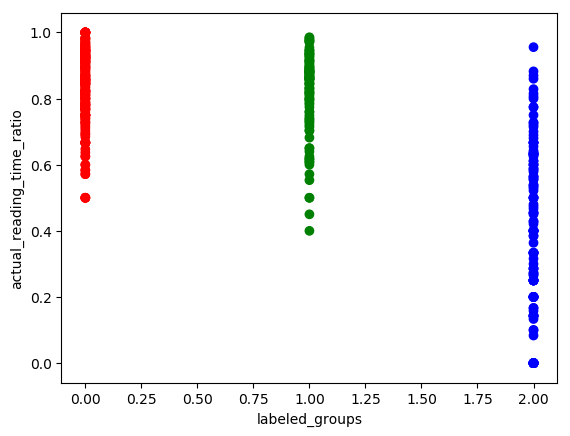

In [165]:
selected_group = k_result
colors = selected_group['color'] 

x = selected_group['label']
y = selected_group['actual_reading_time_ratio']
plt.xlabel('labeled_groups')
plt.ylabel('actual_reading_time_ratio')
ax.scatter(x, y, s=7, c=colors[i])


plt.scatter(x, y, c=colors)
plt.show()

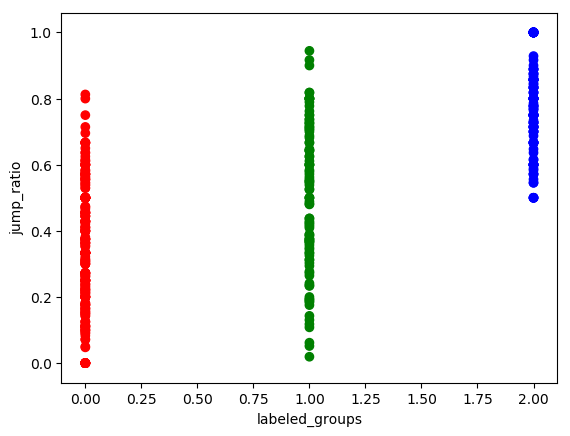

In [166]:
selected_group = k_result
colors = selected_group['color'] 

x = selected_group['label']
y = selected_group['jump_ratio']
plt.xlabel('labeled_groups')
plt.ylabel('jump_ratio')
ax.scatter(x, y, s=7, c=colors[i])


plt.scatter(x, y, c=colors)
plt.show()

# jump_ratio compariosn

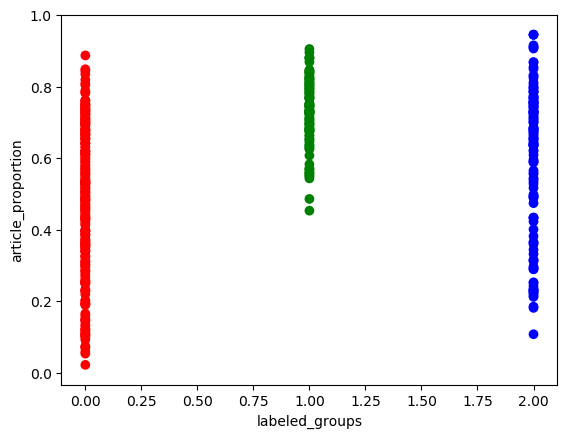

In [167]:
selected_group = k_result
colors = selected_group['color'] 

x = selected_group['label']
y = selected_group['article_proportion']
plt.xlabel('labeled_groups')
plt.ylabel('article_proportion')
ax.scatter(x, y, s=7, c=colors[i])


plt.scatter(x, y, c=colors)
plt.show()


# major_section comparision

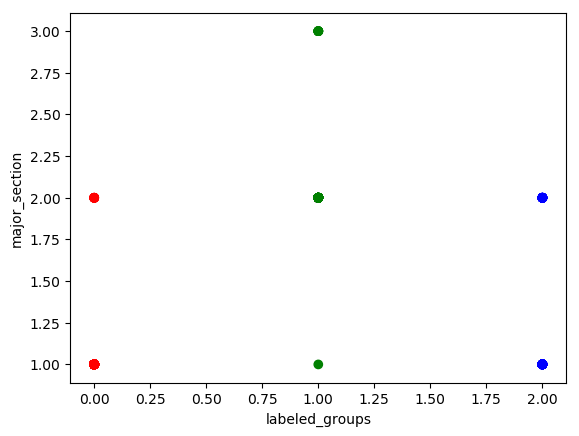

In [168]:
selected_group = k_result
colors = selected_group['color'] 

x = selected_group['label']
y = selected_group['major_section']
plt.xlabel('labeled_groups')
plt.ylabel('major_section')
ax.scatter(x, y, s=7, c=colors[i])


plt.scatter(x, y, c=colors)
plt.show()


# jumping_speed comparision

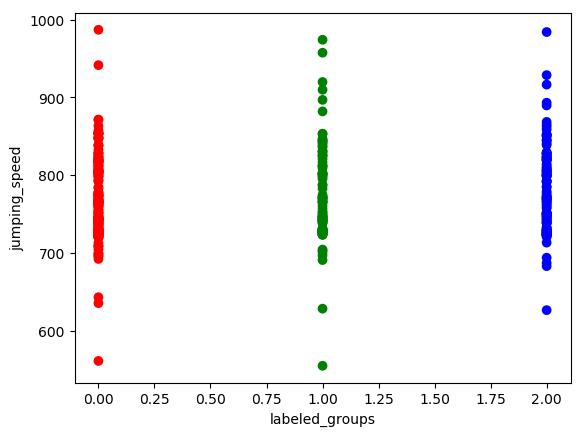

In [169]:
selected_group = k_result
colors = selected_group['color'] 

x = selected_group['label']
y = selected_group['jumping_speed']
plt.xlabel('labeled_groups')
plt.ylabel('jumping_speed')
ax.scatter(x, y, s=7, c=colors[i])


plt.scatter(x, y, c=colors)
plt.show()

# pairwise correlation analysis

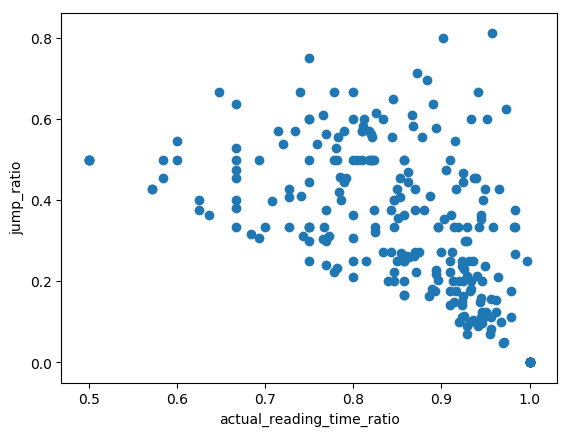

In [170]:
x = label_0['actual_reading_time_ratio']
y = label_0['jump_ratio']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

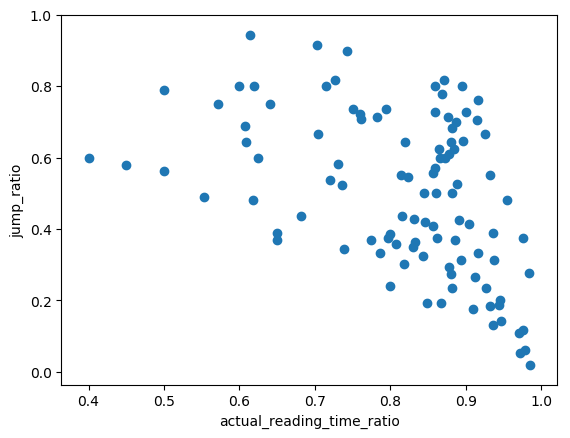

In [171]:
x = label_1['actual_reading_time_ratio']
y = label_1['jump_ratio']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

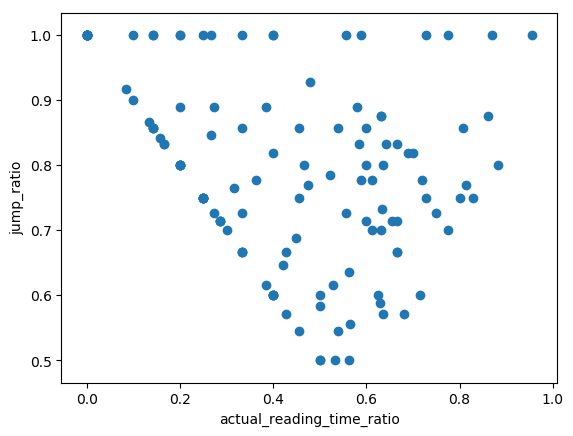

In [172]:
x = label_2['actual_reading_time_ratio']
y = label_2['jump_ratio']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

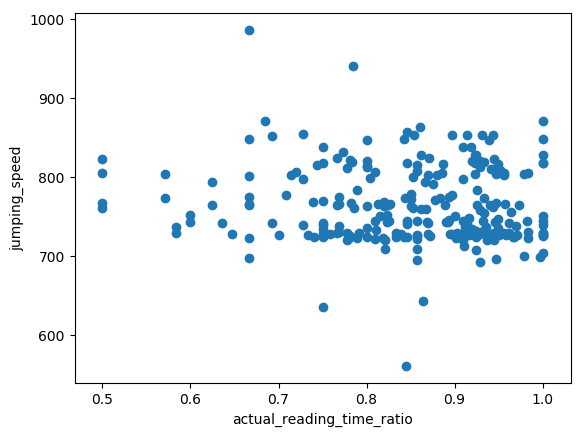

In [173]:
x = label_0['actual_reading_time_ratio']
y = label_0['jumping_speed']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('jumping_speed')
plt.scatter(x, y)

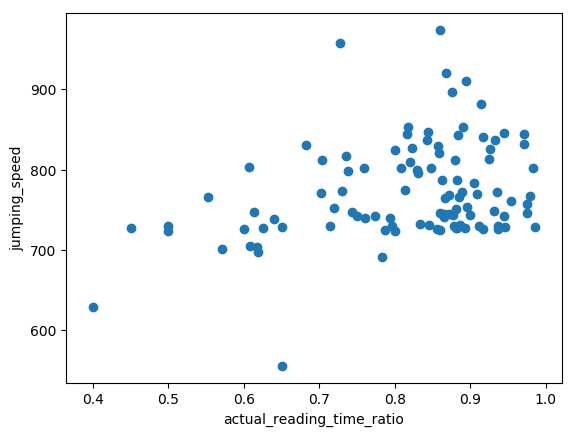

In [174]:
x = label_1['actual_reading_time_ratio']
y = label_1['jumping_speed']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('jumping_speed')
plt.scatter(x, y)

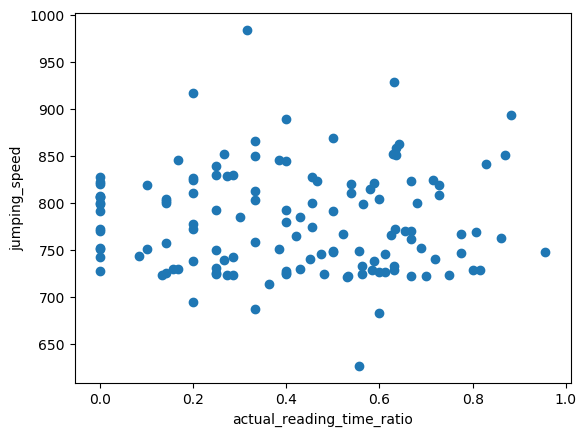

In [175]:
x = label_2['actual_reading_time_ratio']
y = label_2['jumping_speed']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('jumping_speed')
plt.scatter(x, y)

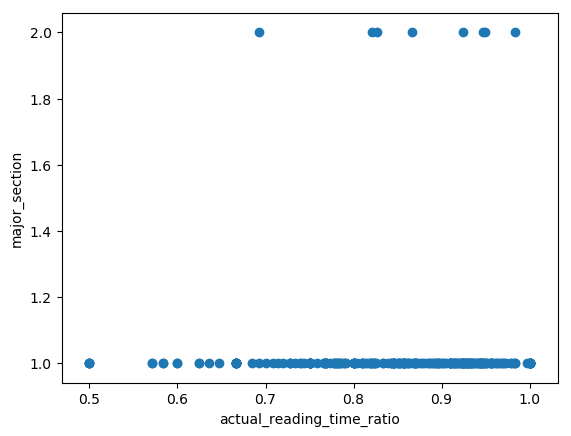

In [176]:
x = label_0['actual_reading_time_ratio']
y = label_0['major_section']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('major_section')
plt.scatter(x, y)

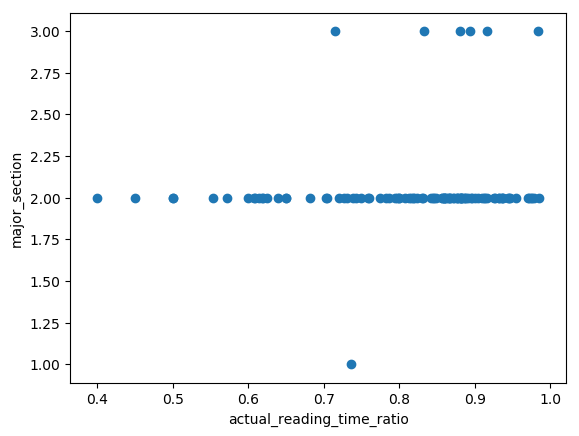

In [177]:
x = label_1['actual_reading_time_ratio']
y = label_1['major_section']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('major_section')
plt.scatter(x, y)

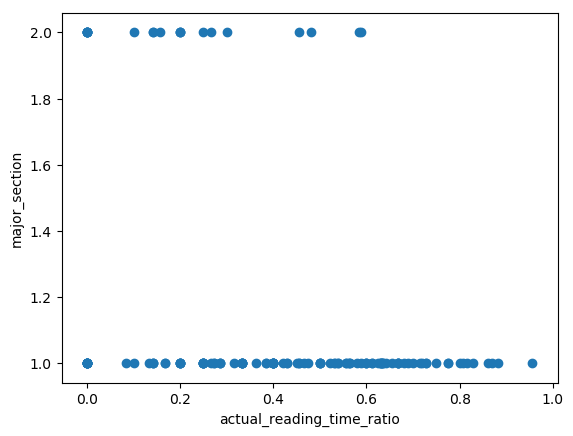

In [178]:
x = label_2['actual_reading_time_ratio']
y = label_2['major_section']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('major_section')
plt.scatter(x, y)

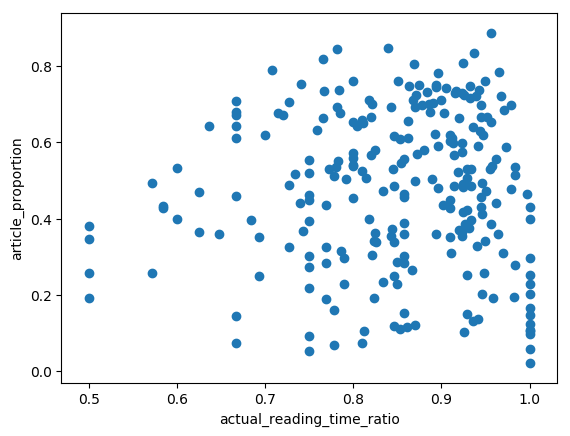

In [179]:
x = label_0['actual_reading_time_ratio']
y = label_0['article_proportion']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('article_proportion')
plt.scatter(x, y)

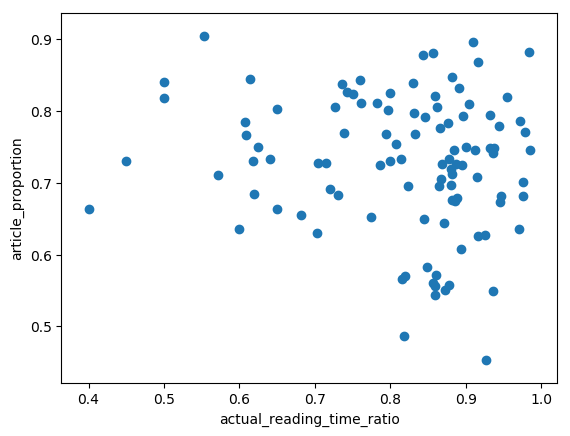

In [180]:
x = label_1['actual_reading_time_ratio']
y = label_1['article_proportion']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('article_proportion')
plt.scatter(x, y)

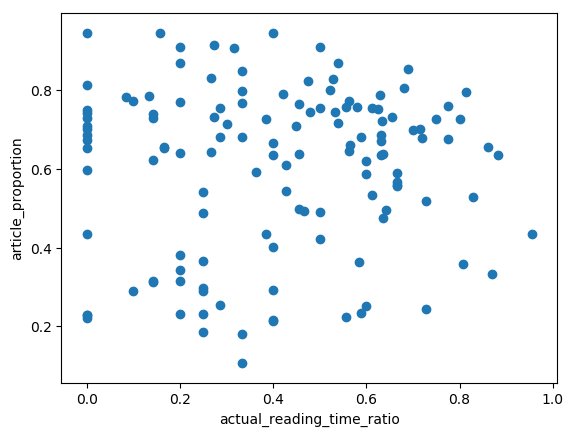

In [181]:
x = label_2['actual_reading_time_ratio']
y = label_2['article_proportion']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('article_proportion')
plt.scatter(x, y)

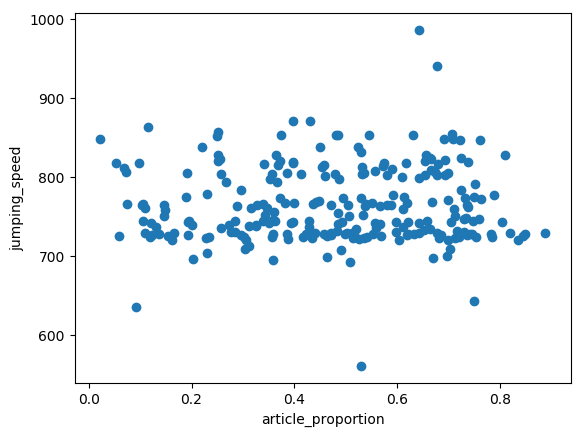

In [182]:
x = label_0['article_proportion']
y = label_0['jumping_speed']
plt.xlabel('article_proportion')
plt.ylabel('jumping_speed')
plt.scatter(x, y)

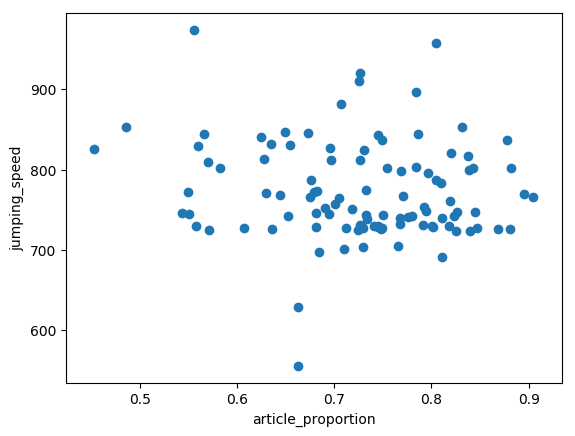

In [183]:
x = label_1['article_proportion']
y = label_1['jumping_speed']
plt.xlabel('article_proportion')
plt.ylabel('jumping_speed')
plt.scatter(x, y)

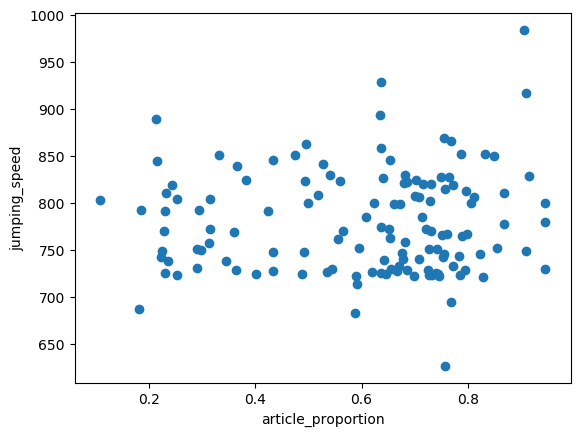

In [184]:
x = label_2['article_proportion']
y = label_2['jumping_speed']
plt.xlabel('article_proportion')
plt.ylabel('jumping_speed')
plt.scatter(x, y)

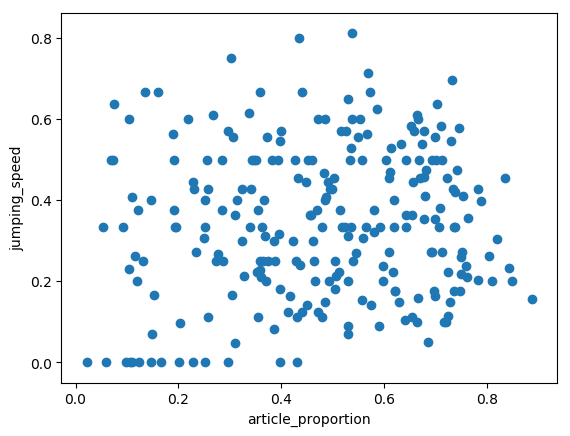

In [185]:
x = label_0['article_proportion']
y = label_0['jump_ratio']
plt.xlabel('article_proportion')
plt.ylabel('jumping_speed')
plt.scatter(x, y)

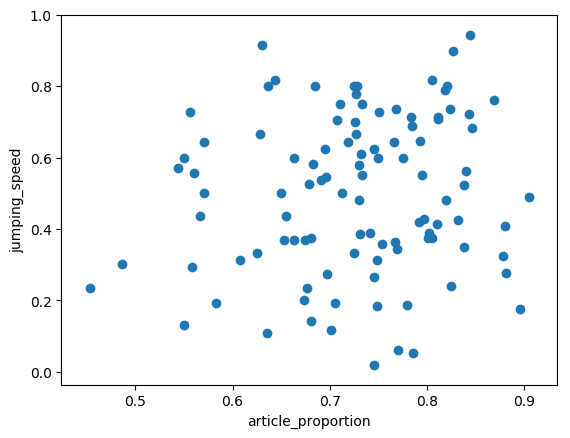

In [186]:
x = label_1['article_proportion']
y = label_1['jump_ratio']
plt.xlabel('article_proportion')
plt.ylabel('jumping_speed')
plt.scatter(x, y)

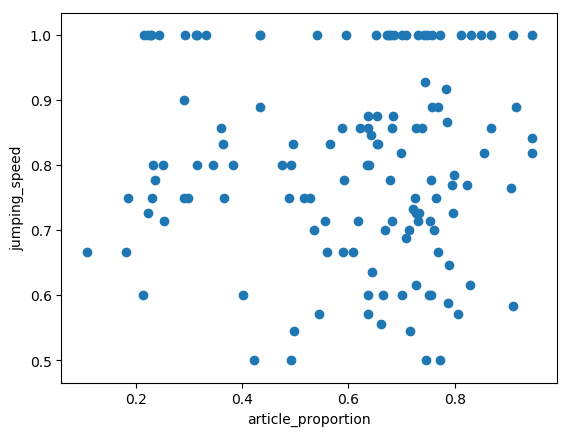

In [187]:
x = label_2['article_proportion']
y = label_2['jump_ratio']
plt.xlabel('article_proportion')
plt.ylabel('jumping_speed')
plt.scatter(x, y)

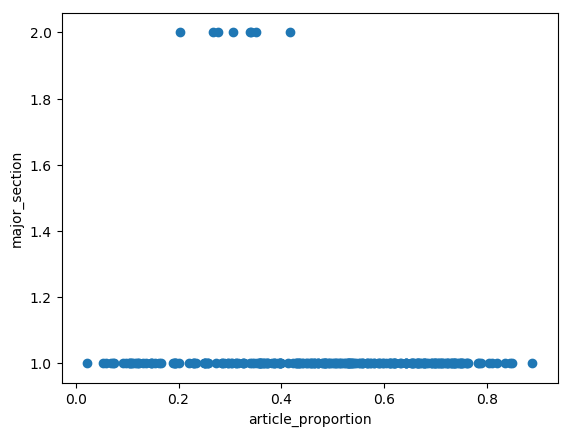

In [188]:
x = label_0['article_proportion']
y = label_0['major_section']
plt.xlabel('article_proportion')
plt.ylabel('major_section')
plt.scatter(x, y)

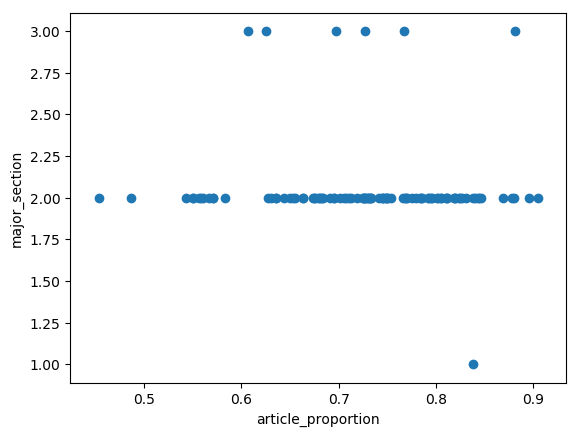

In [189]:
x = label_1['article_proportion']
y = label_1['major_section']
plt.xlabel('article_proportion')
plt.ylabel('major_section')
plt.scatter(x, y)

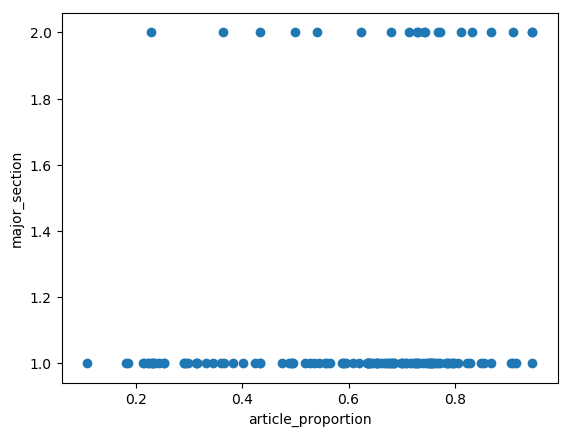

In [190]:
x = label_2['article_proportion']
y = label_2['major_section']
plt.xlabel('article_proportion')
plt.ylabel('major_section')
plt.scatter(x, y)

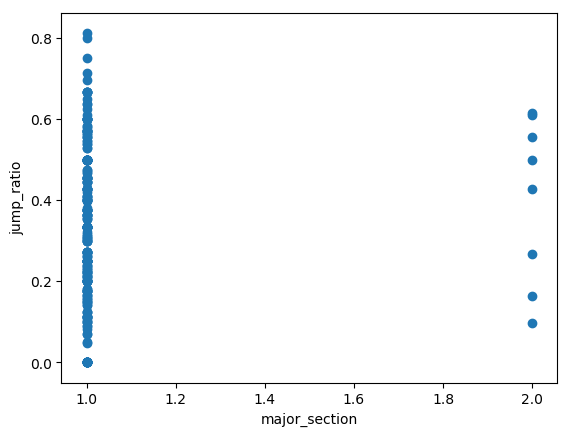

In [191]:
x = label_0['major_section']
y = label_0['jump_ratio']
plt.xlabel('major_section')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

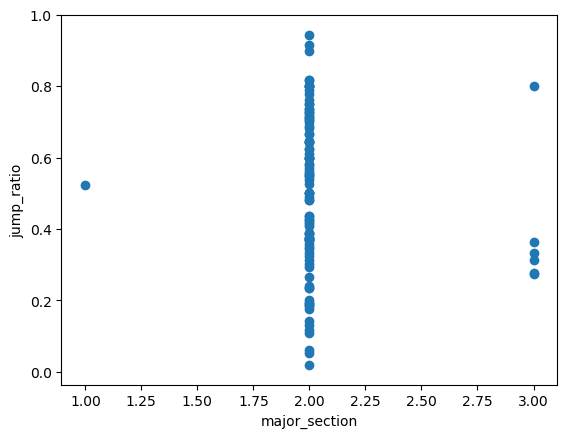

In [192]:
x = label_1['major_section']
y = label_1['jump_ratio']
plt.xlabel('major_section')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

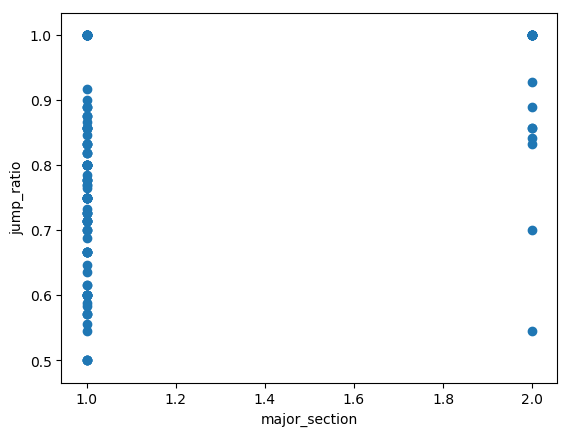

In [193]:
x = label_2['major_section']
y = label_2['jump_ratio']
plt.xlabel('major_section')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

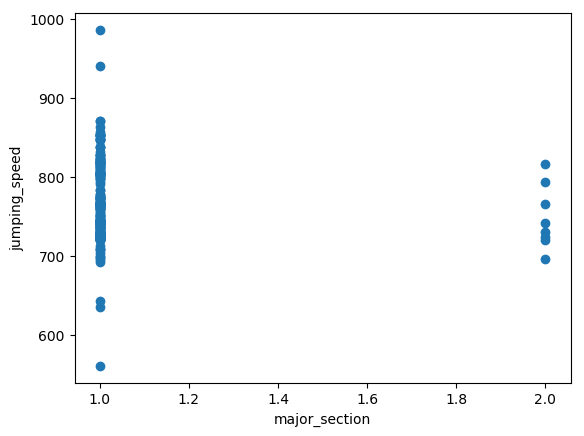

In [194]:
x = label_0['major_section']
y = label_0['jumping_speed']
plt.xlabel('major_section')
plt.ylabel('jumping_speed')
plt.scatter(x, y)

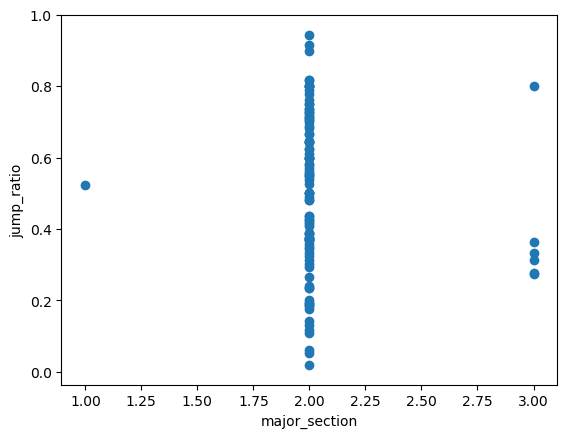

In [195]:
x = label_1['major_section']
y = label_1['jump_ratio']
plt.xlabel('major_section')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

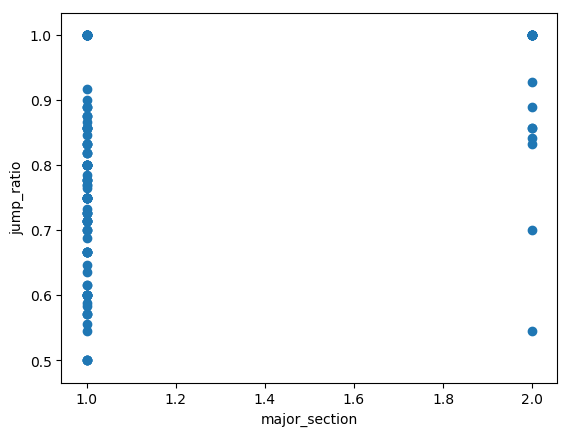

In [196]:
x = label_2['major_section']
y = label_2['jump_ratio']
plt.xlabel('major_section')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

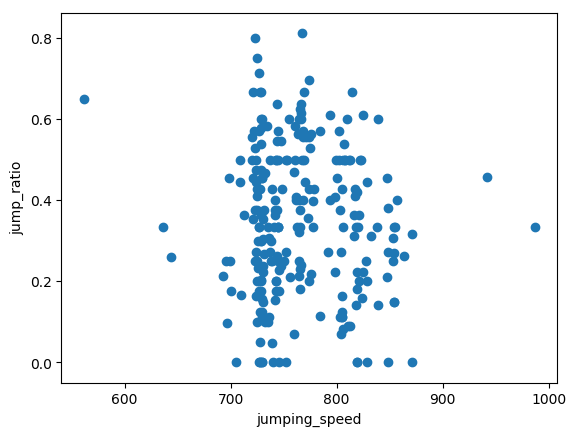

In [197]:
x = label_0['jumping_speed']
y = label_0['jump_ratio']
plt.xlabel('jumping_speed')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

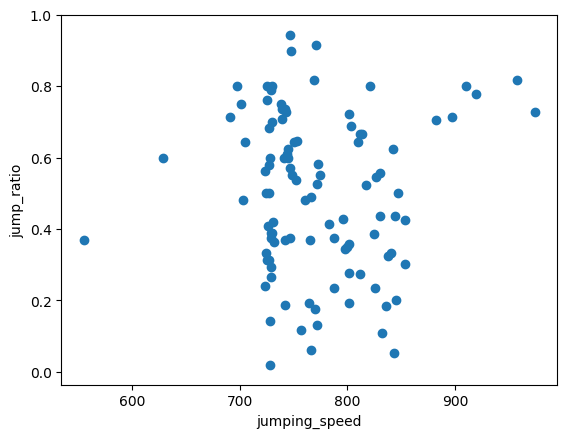

In [198]:
x = label_1['jumping_speed']
y = label_1['jump_ratio']
plt.xlabel('jumping_speed')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

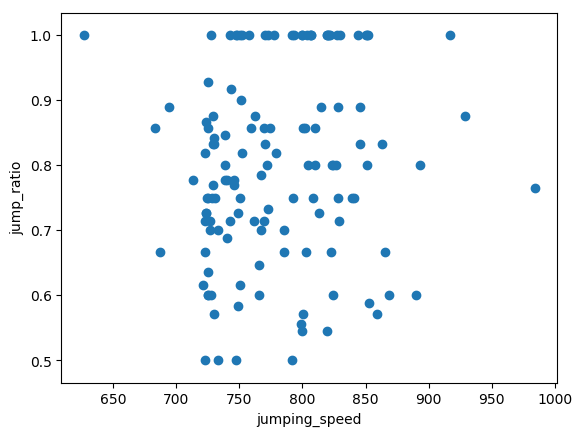

In [199]:
x = label_2['jumping_speed']
y = label_2['jump_ratio']
plt.xlabel('jumping_speed')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

# Clustering By TSNE

In [200]:
from sklearn.manifold import TSNE
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=500, random_state=23)
tsne_values = tsne_model.fit_transform(x_full)



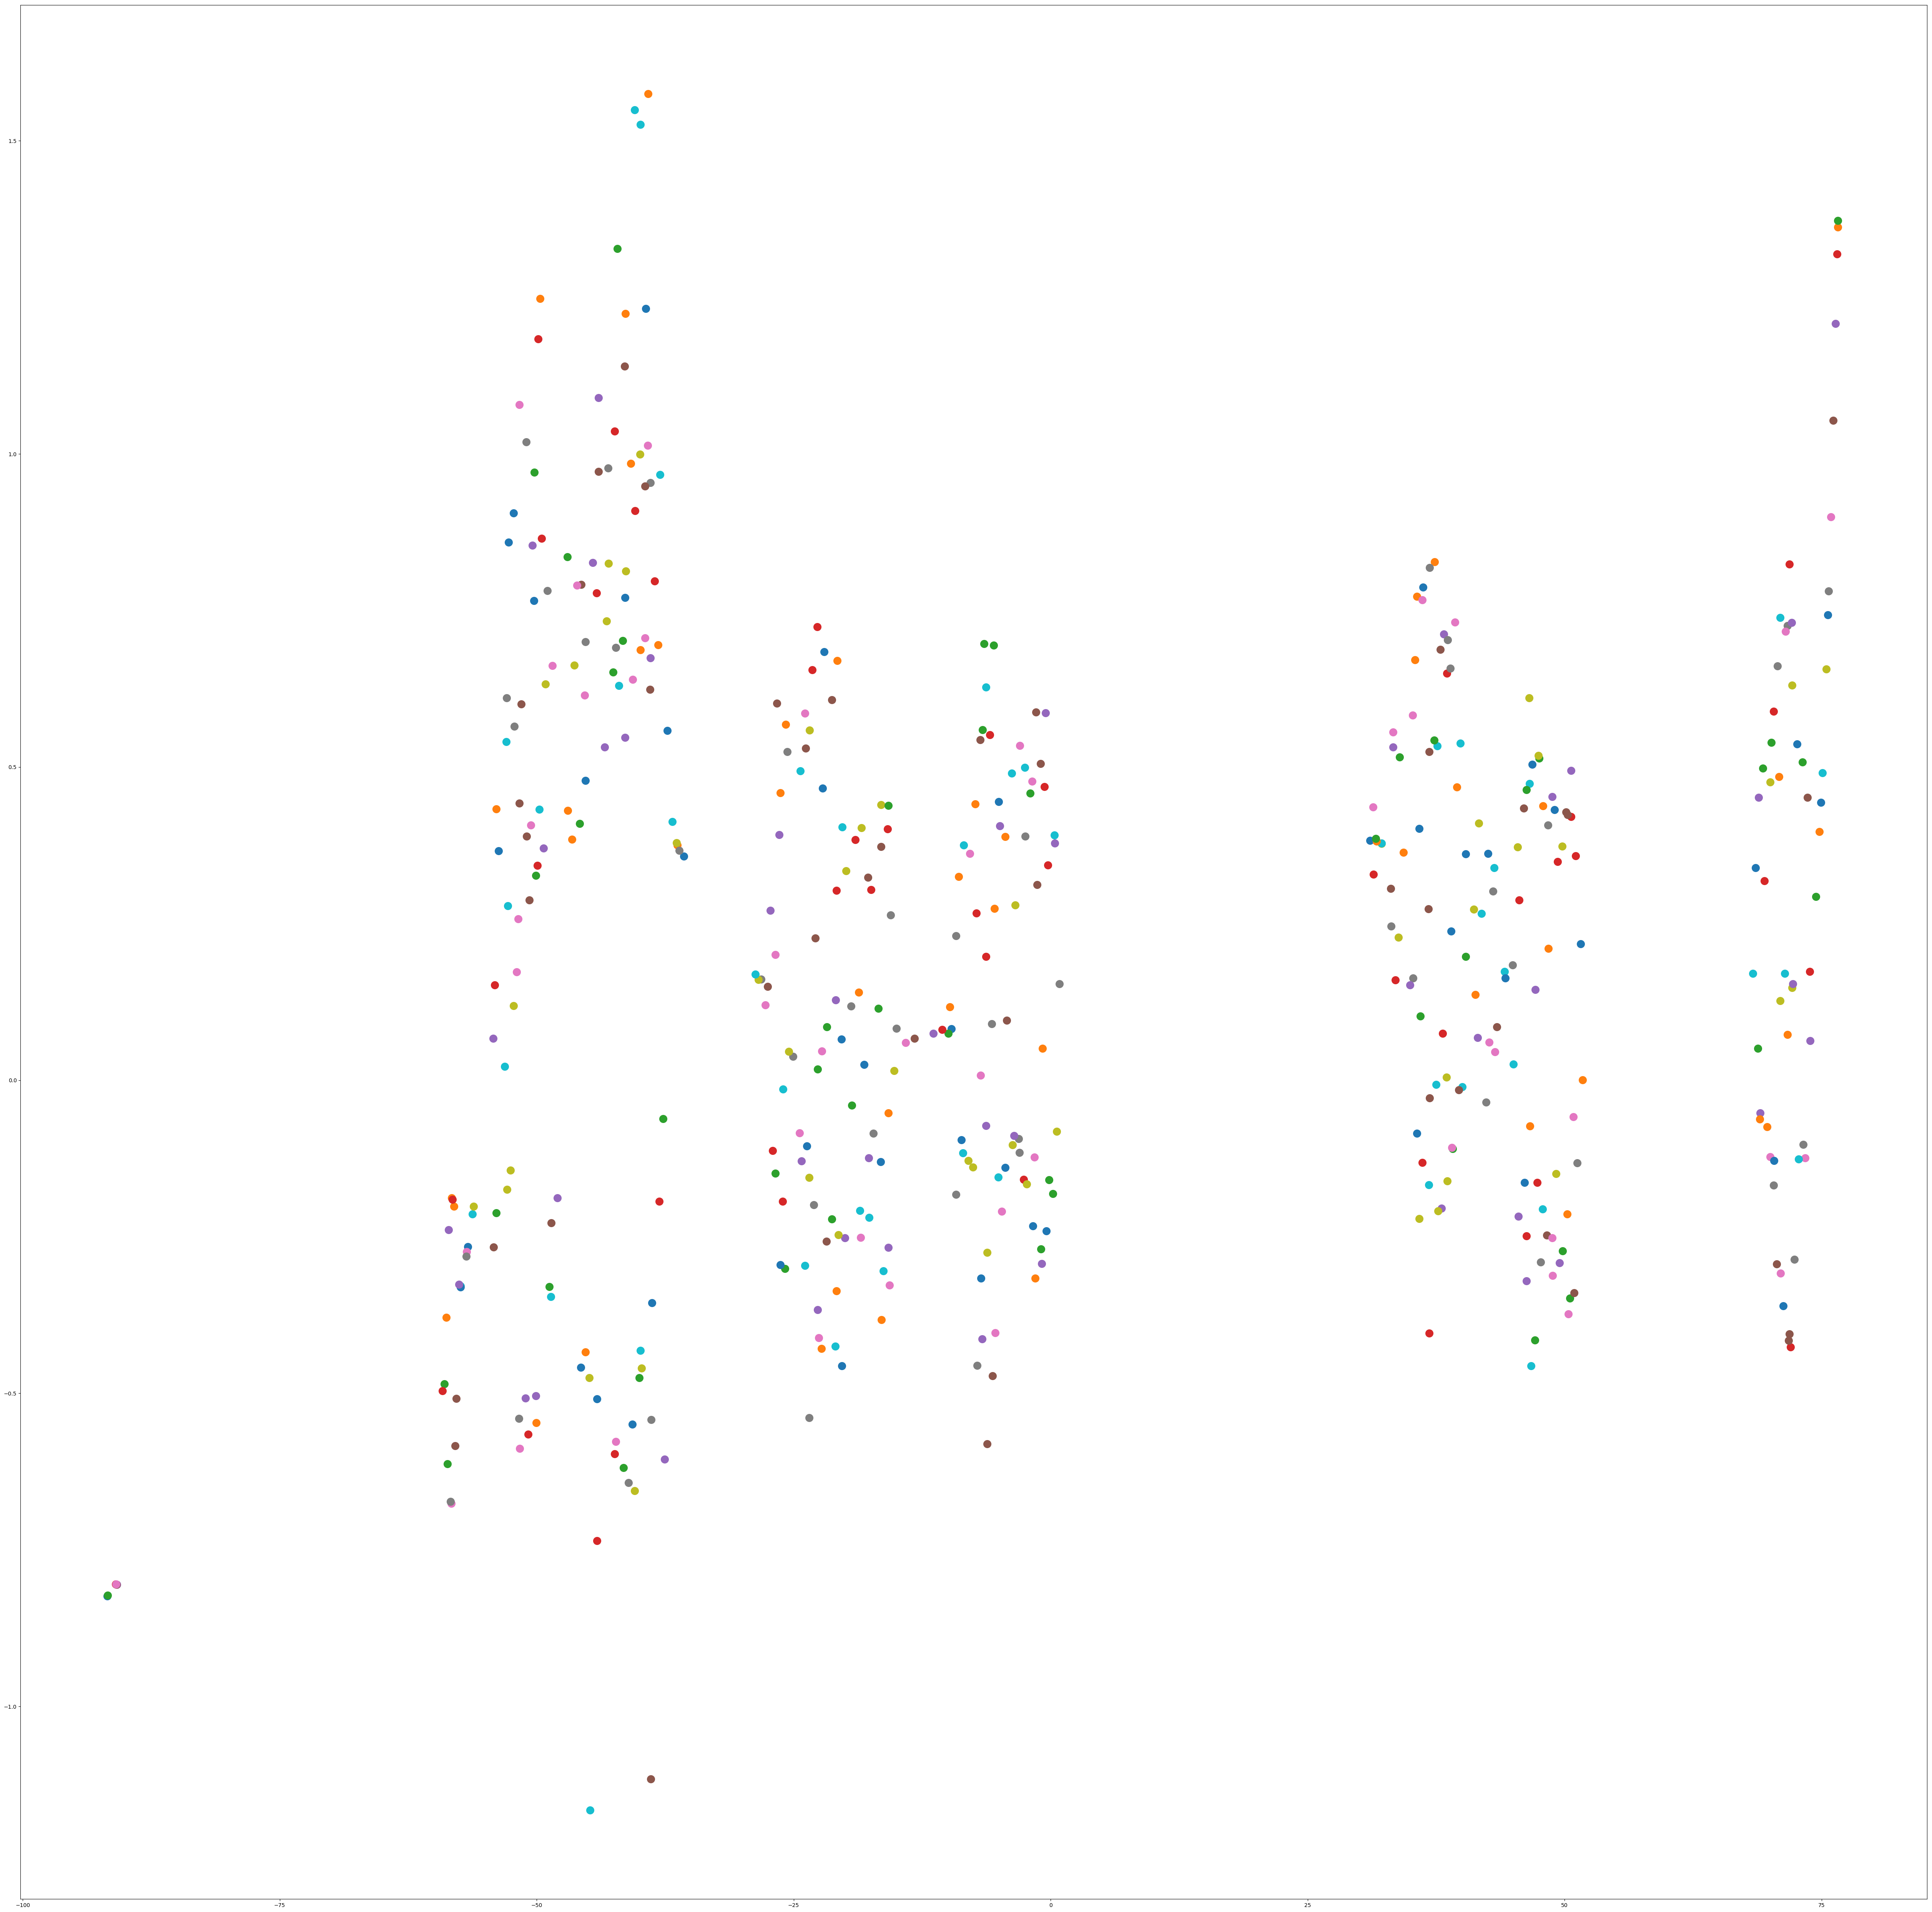

In [201]:
x_tsne = []
y_tsne = []
stne_labels = []
for value in tsne_values:
    x_tsne.append(value[0])
    y_tsne.append(value[1])
    if value[0] < -29 :
        stne_labels.append(1)
    elif  value[0] >= -29 and value[0] < 20 :
        stne_labels.append(2)    
    elif  value[0] >= 20 and value[0] < 60 :
        stne_labels.append(3)
    elif value[0] >= 60:
        stne_labels.append(4)

    
plt.figure(figsize=(64, 64)) 
for i in range(len(x_tsne)):
    plt.scatter(x_tsne[i],y_tsne[i],s = 200)

plt.show()

# labelling data according to t-SNE clustering result

In [202]:
ana_data['label'] = stne_labels
pd.options.display.max_rows = 999
sne_result = ana_data.sort_values(by=['label'])
colors = []

for rows in sne_result['label']:
    if rows == 1:
        colors.append('r')
    elif rows == 2:
        colors.append('g')
    elif rows == 3:
        colors.append("b")
    elif rows == 4:
        colors.append("y")
    elif rows == 5:
        colors.append("c")
sne_result['color'] = colors
label_1 = sne_result[sne_result['label'] == 1]
label_2 = sne_result[sne_result['label'] == 2]
label_3 = sne_result[sne_result['label'] == 3]
label_4 = sne_result[sne_result['label'] == 4]
label_5 = sne_result[sne_result['label'] == 5]

sne_result


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,jumping_speed,jump_ratio,actual_reading_time_ratio,article_proportion,major_section,label,color
36723486 009b8175-f1ca-4f76-be13-5673098f2d14,555.428571,0.368421,0.650000,0.663172,2.0,1,r
44136258 d96a3326-9a4a-4185-9f06-c694ef7057f1,728.342672,0.204545,0.896552,0.782094,1.0,1,r
44137354 d96a3326-9a4a-4185-9f06-c694ef7057f1,727.641265,0.125000,0.950617,0.471349,1.0,1,r
44139459 d96a3326-9a4a-4185-9f06-c694ef7057f1,727.466775,0.050000,0.970588,0.684283,1.0,1,r
44141603 d96a3326-9a4a-4185-9f06-c694ef7057f1,726.929178,0.176471,0.916667,0.735784,1.0,1,r
37314230 d9eb0cea-94da-4fe3-8262-47bf40ebf89b,726.767799,0.333333,0.958333,0.193133,1.0,1,r
37312225 db9b32a3-0a9d-4443-97d9-18f1b639d2c2,727.127119,0.333333,0.700000,0.618132,1.0,1,r
37322599 db9b32a3-0a9d-4443-97d9-18f1b639d2c2,726.616687,0.200000,0.857143,0.464870,1.0,1,r
43465700 ddb6d59b-038d-41da-81fa-00d84487081c,725.614738,0.761905,0.916667,0.868496,2.0,1,r
40247178 de2f2a02-62b7-4346-b92a-13b00ce79e23,726.824163,0.578947,0.450000,0.729572,2.0,1,r


# value ranges comparisons feature by feature 

# jumping_speed comparison

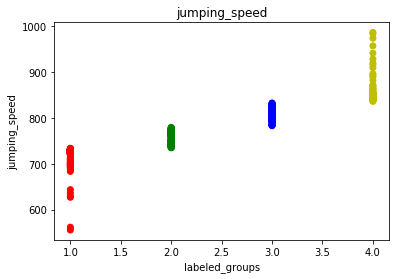

max1 733.8623731804147 max2 779.3951789627465 max3 832.6474576271187 max4 986.94921875
min1 555.4285714285714 min2 734.9902654867257 min3 783.1174551386623 min4 836.3282732447818


In [106]:
selected_group = sne_result#[(sne_resule['label'] == 1) | (sne_resule['label'] ==4)]
colors = selected_group['color'] 

x = selected_group['label']
y = selected_group['jumping_speed']
plt.xlabel('labeled_groups')
plt.ylabel('jumping_speed')
plt.title('jumping_speed')
ax.scatter(x, y, s=7, c=colors[i])


plt.scatter(x, y, c=colors)
plt.show()
max1 = label_1['jumping_speed'].max()
max2 = label_2['jumping_speed'].max()
max3 = label_3['jumping_speed'].max()
max4 = label_4['jumping_speed'].max()

min1 = label_1['jumping_speed'].min()
min2 = label_2['jumping_speed'].min()
min3 = label_3['jumping_speed'].min()
min4 = label_4['jumping_speed'].min()

print("max1" , max1,"max2" , max2,"max3" , max3,"max4" , max4 )
print("min1" , min1,"min2" , min2,"min3" , min3,"min4" , min4 )



# jump_ratio compariosn

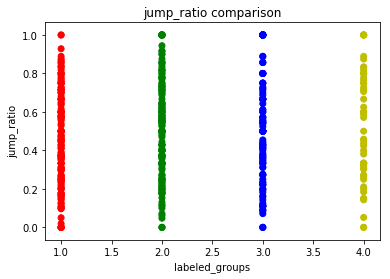

In [107]:
selected_group = sne_result#[(sne_resule['label'] == 1) | (sne_resule['label'] ==4)]
colors = selected_group['color'] 

x = selected_group['label']
y = selected_group['jump_ratio']
plt.xlabel('labeled_groups')
plt.ylabel('jump_ratio')
plt.title("jump_ratio comparison")
ax.scatter(x, y, s=7, c=colors[i])


plt.scatter(x, y, c=colors)
plt.show()


# actual_reading_time_ratio comparision

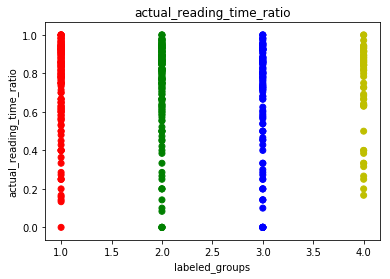

In [108]:
selected_group = sne_result#[(sne_resule['label'] == 1) | (sne_resule['label'] ==4)]
colors = selected_group['color'] 

x = selected_group['label']
y = selected_group['actual_reading_time_ratio']
plt.xlabel('labeled_groups')
plt.ylabel('actual_reading_time_ratio')
plt.title('actual_reading_time_ratio')
ax.scatter(x, y, s=7, c=colors[i])


plt.scatter(x, y, c=colors)
plt.show()

# position_ratio comparison

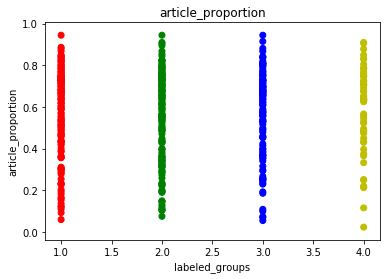

In [109]:
selected_group = sne_result#[(sne_resule['label'] == 1) | (sne_resule['label'] ==4)]
colors = selected_group['color'] 

x = selected_group['label']
y = selected_group['article_proportion']
plt.xlabel('labeled_groups')
plt.ylabel('article_proportion')
plt.title('article_proportion')
ax.scatter(x, y, s=7, c=colors[i])


plt.scatter(x, y, c=colors)
plt.show()


# major_section

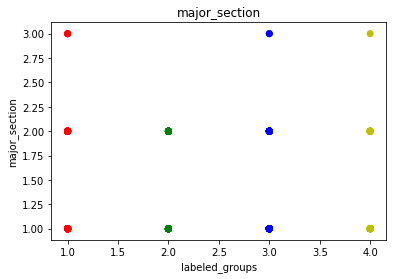

In [110]:
selected_group = sne_result#[(sne_resule['label'] == 1) | (sne_resule['label'] ==4)]
colors = selected_group['color'] 

x = selected_group['label']
y = selected_group['major_section']
plt.xlabel('labeled_groups')
plt.ylabel('major_section')
plt.title('major_section')
ax.scatter(x, y, s=7, c=colors[i])


plt.scatter(x, y, c=colors)
plt.show()



# 

# 

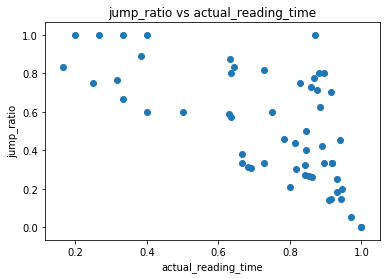

In [122]:
x = label_4['actual_reading_time_ratio']
y = label_4['jump_ratio']
plt.xlabel('actual_reading_time')
plt.ylabel('jump_ratio')
plt.title('jump_ratio vs actual_reading_time')
plt.scatter(x, y)

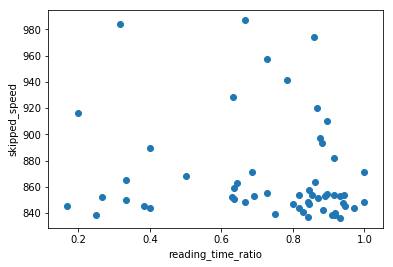

In [123]:
x = label_4['actual_reading_time_ratio']
y = label_4['jumping_speed']
plt.xlabel('reading_time_ratio')
plt.ylabel('skipped_speed')
plt.scatter(x, y)

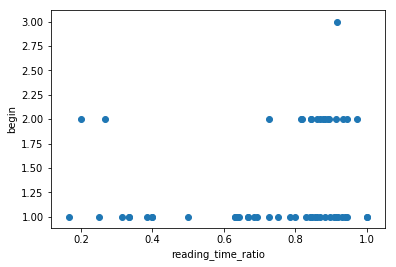

In [124]:
x = label_4['actual_reading_time_ratio']
y = label_4['major_section']
plt.xlabel('reading_time_ratio')
plt.ylabel('begin')
plt.scatter(x, y)

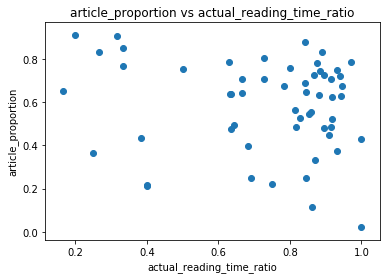

In [125]:
x = label_4['actual_reading_time_ratio']
y = label_4['article_proportion']
plt.xlabel('actual_reading_time_ratio')
plt.ylabel('article_proportion')
plt.title('article_proportion vs actual_reading_time_ratio')
plt.scatter(x, y)

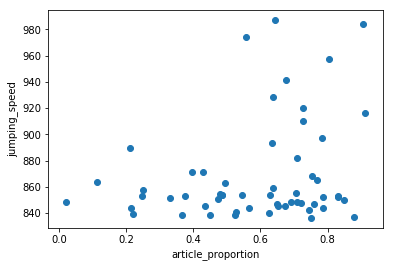

In [126]:
x = label_4['article_proportion']
y = label_4['jumping_speed']
plt.xlabel('article_proportion')
plt.ylabel('jumping_speed')
plt.scatter(x, y)

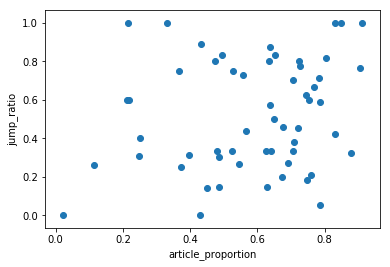

In [127]:
x = label_4['article_proportion']
y = label_4['jump_ratio']
plt.xlabel('article_proportion')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

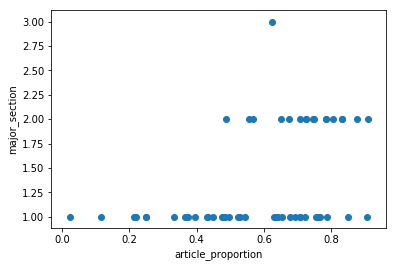

In [128]:
x = label_4['article_proportion']
y = label_4['major_section']
plt.xlabel('article_proportion')
plt.ylabel('major_section')
plt.scatter(x, y)

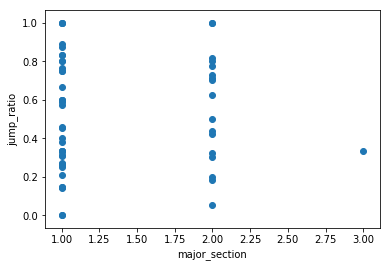

In [129]:
x = label_4['major_section']
y = label_4['jump_ratio']
plt.xlabel('major_section')
plt.ylabel('jump_ratio')
plt.scatter(x, y)

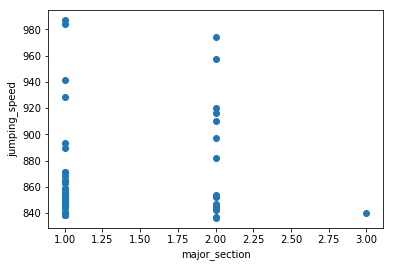

In [130]:
x = label_4['major_section']
y = label_4['jumping_speed']
plt.xlabel('major_section')
plt.ylabel('jumping_speed')
plt.scatter(x, y)

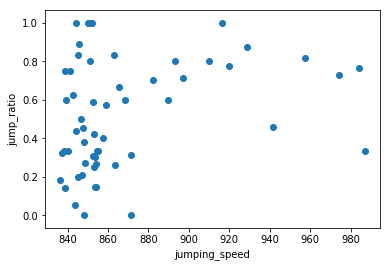

In [131]:
x = label_4['jumping_speed']
y = label_4['jump_ratio']
plt.xlabel('jumping_speed')
plt.ylabel('jump_ratio')
plt.scatter(x, y)
